In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

warnings.simplefilter(action="ignore")

# Adjusting Row Column Settings
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: '%.2f' % x)

df1 = pd.read_excel("datasets/online_retail_II.xlsx", sheet_name = "Year 2009-2010")
df2 = pd.read_excel("datasets/online_retail_II.xlsx", sheet_name = "Year 2010-2011")

df = pd.concat([df1, df2], ignore_index=True)

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom


In [2]:
# Preliminary examination of the data set
def check_df(dataframe, head=5):
    print('##################### Shape #####################')
    print(dataframe.shape)
    print('##################### Types #####################')
    print(dataframe.dtypes)
    print('##################### Head #####################')
    print(dataframe.head(head))
    print('##################### Tail #####################')
    print(dataframe.tail(head))
    print('##################### NA #####################')
    print(dataframe.isnull().sum())
    print('##################### Quantiles #####################')
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(1067371, 8)
##################### Types #####################
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object
##################### Head #####################
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95     13085.00  United Kingdom  
1 2009-12-01 07:45:00   6.75     13085.00  

In [3]:
# Examination of numerical and categorical variables

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note Categorical variables include categorical variables with numeric appearance.
    Parameters
    ------
         dataframe: dataframe
                Dataframe to get variable names
        cat_th: int, optional
                class threshold for numeric but categorical variables
        car_th: int, optinal
                class threshold for categorical but cardinal variables
    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                List of cardinal variables with categorical view
    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))
    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is inside cat_cols.
        The sum of the 3 return lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != 'O']
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == 'O']
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f'Observations: {dataframe.shape[0]}')
    print(f'Variables: {dataframe.shape[1]}')
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car, num_but_cat

cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)


Observations: 1067371
Variables: 8
cat_cols: 0
num_cols: 4
cat_but_car: 4
num_but_cat: 0


In [4]:
# We selected the sales with a sales number greater than zero from df and reassigned it to the df variable.
#The reason for doing this is to remove the purchase returns from the data set.

df = df[(df['Quantity'] > 0)]

df['Quantity'].head()


0    12
1    12
2    12
3    48
4    24
Name: Quantity, dtype: int64

In [5]:
# From the observations in the dataset, we selected the observations that do not contain the C expression.
df = df[df["Invoice"].astype(str).str.contains("C")==False]


In [6]:
# We removed empty observations from the data set.
df.dropna(inplace=True)

df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [7]:
# Creation of TotalPrice
df["TotalPrice"] = df["Quantity"] * df["Price"]


In [8]:
# cltv_c is short name of custome life time value calculation
cltv_c = df.groupby("Customer ID").agg({"Invoice": lambda Invoice: Invoice.nunique(),
                                      "Quantity": lambda Quantity: Quantity.sum(),
                                      "TotalPrice": lambda TotalPrice: TotalPrice.sum()})

cltv_c.head()

,Invoice,Quantity,TotalPrice
Customer ID,,,
12346.00,12,74285,77556.46
12347.00,8,3286,5633.32
12348.00,5,2714,2019.40
12349.00,4,1624,4428.69
12350.00,1,197,334.40


In [9]:
# Changing column names
cltv_c.columns = ["total_transaction", "total_unit", "total_price"]

cltv_c.head()


,total_transaction,total_unit,total_price
Customer ID,,,
12346.00,12,74285,77556.46
12347.00,8,3286,5633.32
12348.00,5,2714,2019.40
12349.00,4,1624,4428.69
12350.00,1,197,334.40


In [10]:
# average_order_value = total_price / total_transaction

cltv_c["average_order_value"] = cltv_c["total_price"] / cltv_c["total_transaction"]

cltv_c.head()

,total_transaction,total_unit,total_price,average_order_value
Customer ID,,,,
12346.00,12,74285,77556.46,6463.04
12347.00,8,3286,5633.32,704.17
12348.00,5,2714,2019.40,403.88
12349.00,4,1624,4428.69,1107.17
12350.00,1,197,334.40,334.40


In [11]:
# Purchase Frequency
# purchase frequency = total_transaction / total_number_of_customers

cltv_c["purchase_frequency"] = cltv_c["total_transaction"] / cltv_c.shape[0]

cltv_c.head()

,total_transaction,total_unit,total_price,average_order_value,purchase_frequency
Customer ID,,,,,
12346.00,12,74285,77556.46,6463.04,0.00
12347.00,8,3286,5633.32,704.17,0.00
12348.00,5,2714,2019.40,403.88,0.00
12349.00,4,1624,4428.69,1107.17,0.00
12350.00,1,197,334.40,334.40,0.00


In [12]:
# Repeat Rate & Churn Rate

# repeat rate = (total_transactio >1) / all customers

# repeat_rate
repeat_rate = cltv_c[cltv_c["total_transaction"] > 1].shape[0] / cltv_c.shape[0]

repeat_rate

# churn rate
churn_rate = 1 - repeat_rate

churn_rate

0.276483591225982

In [13]:
# Profit Margin

# profit_margin = total_price * 0.10

cltv_c["profit_margin"] = cltv_c["total_price"] * 0.10

cltv_c.head()

,total_transaction,total_unit,total_price,average_order_value,purchase_frequency,profit_margin
Customer ID,,,,,,
12346.00,12,74285,77556.46,6463.04,0.00,7755.65
12347.00,8,3286,5633.32,704.17,0.00,563.33
12348.00,5,2714,2019.40,403.88,0.00,201.94
12349.00,4,1624,4428.69,1107.17,0.00,442.87
12350.00,1,197,334.40,334.40,0.00,33.44


In [14]:
# Customer Value
# customer_value = average_order_value * purchase_frequency

cltv_c["customer_value"] = cltv_c["average_order_value"] * cltv_c["purchase_frequency"]

cltv_c.head()

,total_transaction,total_unit,total_price,average_order_value,purchase_frequency,profit_margin,customer_value
Customer ID,,,,,,,
12346.00,12,74285,77556.46,6463.04,0.00,7755.65,13.19
12347.00,8,3286,5633.32,704.17,0.00,563.33,0.96
12348.00,5,2714,2019.40,403.88,0.00,201.94,0.34
12349.00,4,1624,4428.69,1107.17,0.00,442.87,0.75
12350.00,1,197,334.40,334.40,0.00,33.44,0.06


In [15]:
# Customer Lifetime Value

# CLTV = (customer_value / churn_rate) x profit_margin

cltv_c["cltv"] = (cltv_c["customer_value"] / churn_rate) * cltv_c["profit_margin"]

cltv_c.head()

cltv_c.sort_values(by="cltv", ascending=False).head(10)


,total_transaction,total_unit,total_price,average_order_value,purchase_frequency,profit_margin,customer_value,cltv
Customer ID,,,,,,,,
18102.00,145,188340,608821.65,4198.77,0.02,60882.17,103.52,22796051.75
14646.00,152,367833,528602.52,3477.65,0.03,52860.25,89.88,17184540.23
14156.00,156,165992,313946.37,2012.48,0.03,31394.64,53.38,6061643.50
14911.00,398,150237,295972.63,743.65,0.07,29597.26,50.33,5387441.43
17450.00,51,85368,246973.09,4842.61,0.01,24697.31,42.00,3751273.50
13694.00,143,189205,196482.81,1374.01,0.02,19648.28,33.41,2374261.66
17511.00,60,119656,175603.55,2926.73,0.01,17560.36,29.86,1896470.28
16446.00,2,80997,168472.50,84236.25,0.00,16847.25,28.65,1745570.93
16684.00,55,104810,147142.77,2675.32,0.01,14714.28,25.02,1331549.49


In [16]:
# Creating segment Variable

cltv_c["segment"] = pd.qcut(cltv_c["cltv"], 4, labels=["D", "C", "B", "A"])
cltv_c.head(10)


cltv_c.sort_values(by="cltv", ascending=False).head(10)

cltv_c.groupby("segment").agg({"count", "mean", "sum"})

total_transaction             total_unit               total_price  \
                      sum count  mean        sum count    mean         sum   
segment                                                                      
D                    1911  1471  1.30     199258  1471  135.46   286503.06   
C                    3643  1470  2.48     505745  1470  344.04   852347.92   
B                    7014  1470  4.77    1299830  1470  884.24  2124449.83   
A                   24407  1470 16.60    8716088  1470 5929.31 14480128.36   

                      average_order_value              purchase_frequency  \
        count    mean                 sum count   mean                sum   
segment                                                                     
D        1471  194.77           243467.99  1471 165.51               0.32   
C        1470  579.83           437562.15  1470 297.66               0.62   
B        1470 1445.20           584790.16  1470 397.82               1.19   
A        1470 9850.43          1036698.43  1470 705.24               4.15   

                   profit_margin              customer_value             \
        count mean           sum count   mean            sum count mean   
segment                                                                   
D        1471 0.00      28650.31  1471  19.48          48.72  1471 0.03   
C        1470 0.00      85234.79  1470  57.98         144.93  1470 0.10   
B        1470 0.00     212444.98  1470 144.52         361.24  1470 0.25   
A        1470 0.00    1448012.84  1470 985.04        2462.19  1470 1.67   

               cltv                 
                sum count     mean  
segment                             
D           4124.37  1471     2.80  
C          32689.17  1470    22.24  
B         203222.90  1470   138.25  
A       81558808.67  1470 55482.18

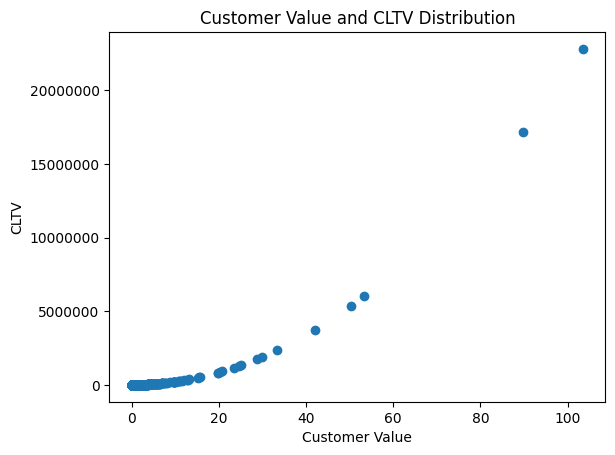

In [17]:
# The relationship between customer_value and customer lifetime value (CLTV)
plt.scatter(cltv_c['customer_value'], cltv_c['cltv'])
plt.title("Customer Value and CLTV Distribution")
plt.xlabel("Customer Value")
plt.ylabel("CLTV")
plt.ticklabel_format(style='plain', axis='both')

# Show the plot
plt.show()

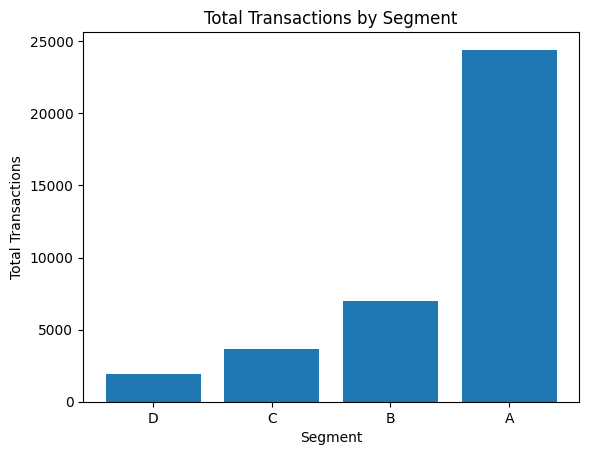

In [18]:
# Calculating total transactions by segment
segment_transaction = cltv_c.groupby('segment')['total_transaction'].sum()

plt.bar(segment_transaction.index, segment_transaction.values)
plt.title("Total Transactions by Segment")
plt.xlabel("Segment")
plt.ylabel("Total Transactions")


plt.show()


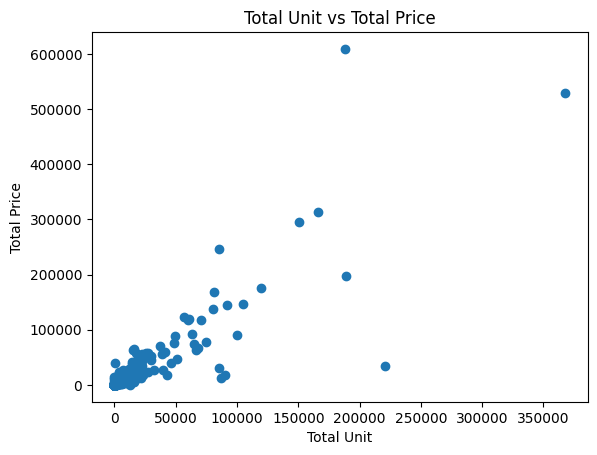

In [19]:
# Total Unit ve Total Price

plt.scatter(cltv_c['total_unit'], cltv_c['total_price'])
plt.title("Total Unit vs Total Price")
plt.xlabel("Total Unit")
plt.ylabel("Total Price")
plt.show()

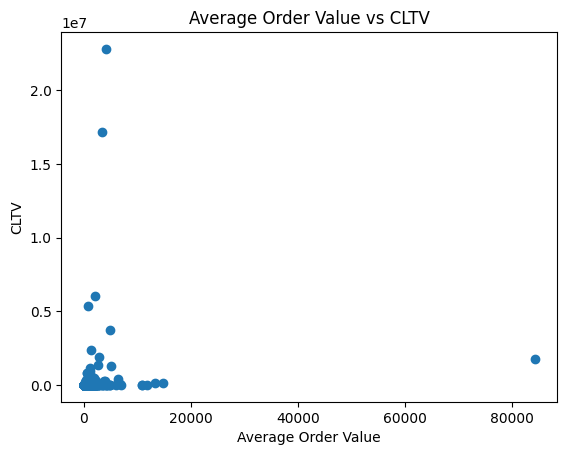

In [20]:
# Average Order Value ve CLTV
plt.scatter(cltv_c['average_order_value'], cltv_c['cltv'])
plt.title("Average Order Value vs CLTV")
plt.xlabel("Average Order Value")
plt.ylabel("CLTV")
plt.show()

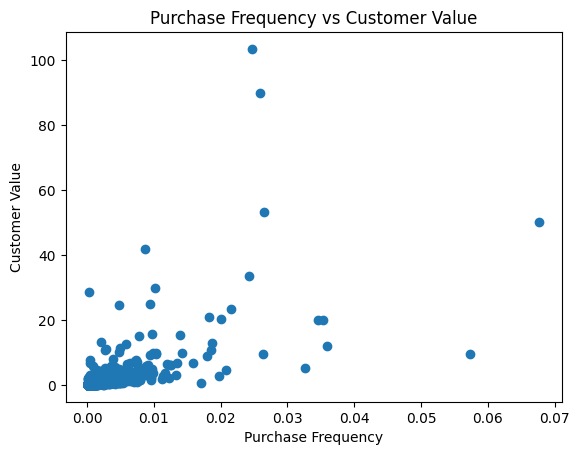

In [21]:
# Purchase Frequency ve Customer Value
plt.scatter(cltv_c['purchase_frequency'], cltv_c['customer_value'])
plt.title("Purchase Frequency vs Customer Value")
plt.xlabel("Purchase Frequency")
plt.ylabel("Customer Value")
plt.show()

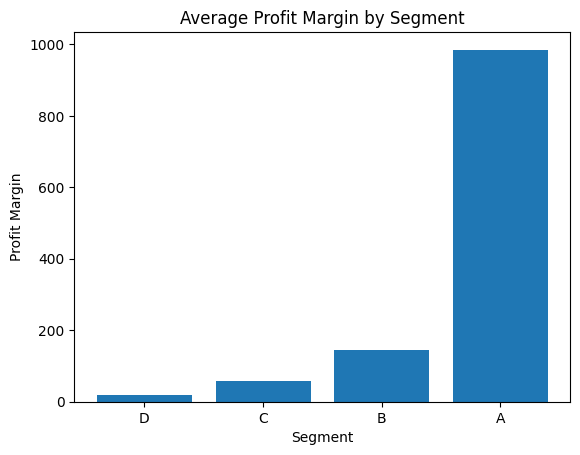

In [22]:
# Profit Margin ve Segment
profit_margin_segment = cltv_c.groupby('segment')['profit_margin'].mean()

plt.bar(profit_margin_segment.index, profit_margin_segment.values)
plt.title("Average Profit Margin by Segment")
plt.xlabel("Segment")
plt.ylabel("Profit Margin")
plt.show()